In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- Official statistics on total deaths are at: https://www.scb.se/en/finding-statistics/statistics-by-subject-area/population/population-composition/population-statistics $\to$  Preliminary statistics on deaths. Importantly, while this dataset has a release date, it does also have an update date (so gets updated more frequently). This is particularly important for the issue of under-reporting as figures get retroactively corrected (mostly upwards). For the most recent days, the figures are very low and so are not usable for our analysis. In practice we therefore stop four days before the last available day (current last available day: 2020-04-09, we stop at 2020-04-05).  

- Official statistics on Covid-19 mortality are at: https://www.folkhalsomyndigheten.se/smittskydd-beredskap/utbrott/aktuella-utbrott/covid-19/bekraftade-fall-i-sverige/ $\to$ "Data som statistiken ovan bygger på kan laddas ner här (Excel)"

# 1) Processign the total death data

In [2]:
def convert_months(month):
    
    months = {}
    months['april'] = '04'
    months['augusti'] = '08'
    months['december'] = '12'
    months['februari'] = '02'
    months['januari'] = '01'
    months['juli'] = '07'
    months['juni'] = '06'
    months['maj'] = '05'
    months['mars'] = '03'
    months['november'] = '11'
    months['oktober'] = '10'
    months['september'] = '09'
    
    return months[month]


In [3]:
df = pd.read_excel('./total_death/2020-04-17---preliminar-statistik-over-doda-inkl-eng.xlsx', sheet_name='Tabell 1', skiprows=6)

In [4]:
df = df[['DagMånad', 2015, 2016, 2017, 2018, 2019, 2020]].iloc[:-1,:].reset_index(drop=True).copy(deep=True)

## 1.1) Initial cleaning and construction of date variable

In [5]:
df['manad'] = df.DagMånad.apply(lambda x: re.search('.+?\s(.+)', x).group(1))
df['day'] = df.DagMånad.apply(lambda x: re.search('(.+?)\s.+', x).group(1))
df['day'] = ('0'+df['day'].astype('str')).str[-2:]
df['month'] = df.manad.apply(lambda x: convert_months(x))
df = df.drop(['DagMånad', 'manad'], axis=1)
df['date'] = "2020-" + df['month'] + "-" + df['day']
df['date']  =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')

the following plot illustrates the issue of reporting delay

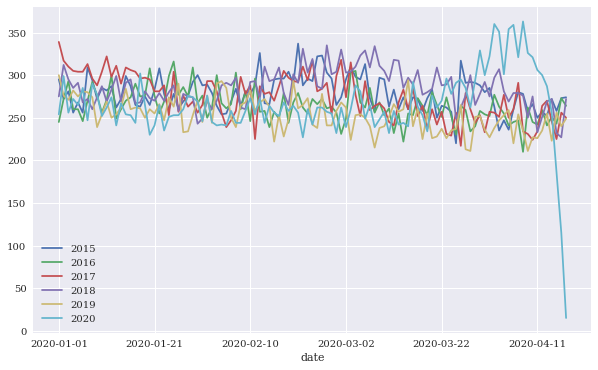

In [6]:
df_rd = df[(df.date <= '2020-04-17') & (df.date != '2020-02-29')].reset_index(drop=True).drop(['day', 'month'], axis=1).copy(deep=True)
df_rd.index=df_rd.date
del df_rd['date']
df_rd.plot(figsize=(10, 6))
plt.show()

In [7]:
df = df[(df.date >= '2020-03-10') & (df.date <= '2020-04-13')].reset_index(drop=True)
df = df.drop(['day', 'month'], axis=1)
df.columns = ['{}'.format(yr) for yr in range(2015, 2021)] + ['date']

computing cumulative sums

In [8]:
for yr in range(2015, 2021):
    df['cs_{}'.format(yr)] = df['{}'.format(yr)].cumsum()
    del df['{}'.format(yr)]

computing daily growth rates

In [9]:
for yr in range(2015, 2020):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

computing average of daily growth rates 15-19

In [10]:
df['daily_growth'] = df.loc[:,['gr_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['gr_{}'.format(yr) for yr in range(2015,2020)], axis=1)

extrapolating forward

In [11]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.date=='2020-03-10','cs_2020'].values[0]

In [12]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'daily_growth']

In [13]:
df = df.drop(['daily_growth'], axis=1)

# 2) Processing Covid-19 death data

In [14]:
official = pd.read_excel('./covid_deaths/Folkhalsomyndigheten_Covid19.xlsx', sheet_name='Antal avlidna per dag')

In [15]:
official['date'] = official.Datum_avliden.astype('str').str[:10]
official['date']  =  pd.to_datetime(official['date'] , format='%Y%m%d', errors='ignore')
del official['Datum_avliden']
official['covid_deaths'] = official.Antal_avlidna.cumsum()
del official['Antal_avlidna']
official = official.iloc[:-1,:].reset_index(drop=True).copy(deep=True)

# 3) Merging and plotting

In [16]:
df = pd.merge(df, official, on=['date'], how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual + df.covid_deaths
del df['covid_deaths']
df.index = df.date
del df['date']

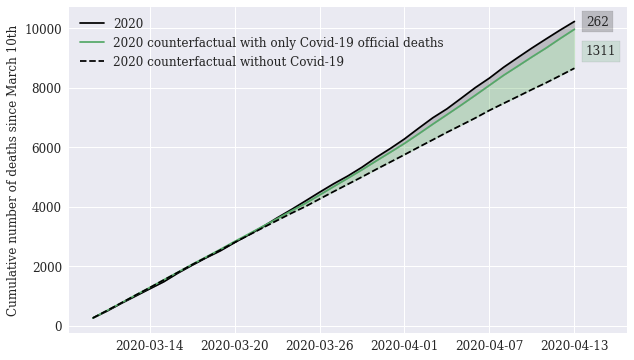

In [17]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')

ax.set_xticks(df.index[[4,10,16,22,28,34]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since March 10th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 2

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(34.8, 9100, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)


plt.text(34.8, 10100, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_sweden.pdf', bbox_inches='tight', dpi=100)

In [18]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 1311.0 = green - dashed black
Excess deaths: 1573.0 = solid black - dashed black
Unexplained excess deaths: 262.0 = solid black - green
